In [95]:
# Code source: Patrick Kunzmann (Biotite)
#
# Modified to read NCBI annotations: Conny Yu
# Requires biotite and biopython
#
# 1. Search the pdb code for proteins on https://www.ncbi.nlm.nih.gov/ 
# 2. Download the annotation for the specific chain
# 3. Change the file name in input_file
# note that no. of amino acids might not match the actual protein (missing loop, cleavage scar, etc)
# always check the actual pdb file
#

In [96]:
from tempfile import gettempdir
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
import biotite
import biotite.sequence as seq
import biotite.sequence.graphics as graphics

# Create 'FeaturePlotter' subclasses
# for drawing the scondary structure features

class HelixPlotter(graphics.FeaturePlotter):

    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False
    
    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2*np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4*np.sin(x_val) + 1) / 2
        
        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2*np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0
        
        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(
            x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"]
        )

class SheetPlotter(graphics.FeaturePlotter):

    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width


    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False
    
    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height/2
        dx = bbox.width
        dy = 0
        
        if  loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True
        
        axes.add_patch(biotite.AdaptiveFancyArrow(
            x, y, dx, dy,
            self._tail_width*bbox.height, self._head_width*bbox.height,
            # Create head with 90 degrees tip
            # -> head width/length ratio = 1/2
            head_ratio=0.5, draw_head=draw_head,
            color=biotite.colors["orange"], linewidth=0
        ))

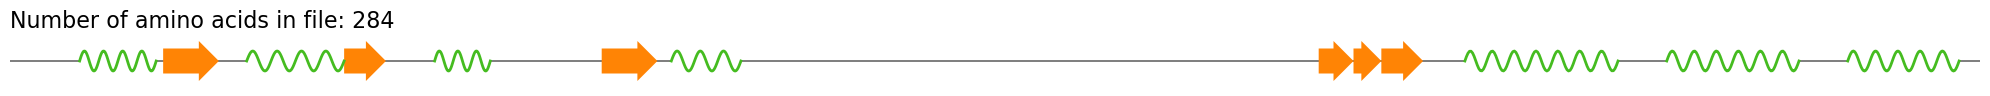

In [97]:
import re
import os

# Define the regular expressions
features_pattern = r"(\w+)\s+(\d+)\.\.(\d+)\s+/sec_str_type=\"(\w+)\""
source_pattern = r"source\s+(\d+)\.\.(\d+)"

# Input file name
input_file = '3A1Y_G.gp'
# Extract the base name of the input file without extension
file_name = os.path.splitext(input_file)[0]

# Open the file for reading
with open(input_file, 'r') as file:
    content = file.read()

# Extract the features
features_matches = re.findall(features_pattern, content)

# Extract the source location
source_match = re.search(source_pattern, content)
seq_length = int(source_match.group(2))

# Generating the annotation for Biotite
features = []
for match in features_matches:
    start = int(match[1])
    end = int(match[2])
    sec_str_type = match[3]
    location = seq.Location(start, end)
    qualifiers = {"sec_str_type": sec_str_type}
    feature = seq.Feature("SecStr", [location], qualifiers)
    features.append(feature)

annotation = seq.Annotation(features)

fig = plt.figure(figsize=(20, 0.8))
ax = fig.add_subplot(111)
graphics.plot_feature_map(
    ax, annotation, multi_line=False, loc_range=(1, seq_length),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)
fig.tight_layout()

ax.set_title(f"Number of amino acids in file: {seq_length}", loc='left', size='16')

# Save the figure with the input file name as PDF
output_file = f"output/{file_name}.pdf"
plt.savefig(output_file, format='pdf')
plt.show()